<a href="https://colab.research.google.com/github/COS-IT-FLOWS/Impacts/blob/main/Area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Install necessary packages
# !pip install numpy

import osgeo.gdal as gdal
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, ogr
from osgeo import ogr
from google.colab import drive

def process_raster_data(input_filename, output_filename, output_vector_filename, threshold):
    """
    Process raster data by converting grid values less than or equal to the threshold as 1 and rest as -9999.9,
    then save the modified data to a new TIFF file and create a vector shapefile from the modified raster.

    Args:
        input_filename (str): The path to the input TIFF file.
        output_filename (str): The path to the output TIFF file.
        output_vector_filename (str): The path to the output vector shapefile.
        threshold (float): The threshold value for processing the raster data.
    """

    # Open the TIFF file using GDAL
    gdal_data = gdal.Open(input_filename)

    # Get the first raster band
    gdal_band = gdal_data.GetRasterBand(1)

    # Get the no-data value
    nodataval = gdal_band.GetNoDataValue()
    print(nodataval)

    # Convert the TIFF data to a numpy array
    data_array = gdal_data.ReadAsArray().astype(float)

    # Replace missing values with NaN if necessary
    # if np.any(data_array == nodataval):
    #     data_array[data_array == nodataval] = np.nan

    # Convert raster grid values: set values <= threshold as 1 and others as -9999.9
    data_array = np.where(np.logical_and(data_array > nodataval, data_array <= threshold), 1, -9999.9)

    # gdal_band.SetNoDataValue(-9999.9)

    # Create a new TIFF file
    driver = gdal.GetDriverByName('GTiff')
    output_data = driver.Create(output_filename, data_array.shape[1], data_array.shape[0], 1, gdal.GDT_Float32)

    # Set the geotransform and projection from the original file
    output_data.SetGeoTransform(gdal_data.GetGeoTransform())
    output_data.SetProjection(gdal_data.GetProjection())

    # Write the modified array to the new file
    output_band = output_data.GetRasterBand(1)
    output_band.WriteArray(data_array)

    # Close the output file
    output_data = None

    # Plot the modified raster data
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Modified Raster Data (Threshold: {threshold})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.imshow(data_array, cmap="inferno", extent=(gdal_data.GetGeoTransform()[0],
                                                gdal_data.GetGeoTransform()[0] + gdal_data.GetGeoTransform()[1] * data_array.shape[1],
                                                gdal_data.GetGeoTransform()[3] + gdal_data.GetGeoTransform()[5] * data_array.shape[0],
                                                gdal_data.GetGeoTransform()[3]))

    ax.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout to fit the figure area

    plt.show()

    # Convert the modified raster to a vector shapefile in WGS 84 projection
    raster_to_vector(output_filename, output_vector_filename)

def raster_to_vector(input_raster, output_vector):
    """
    Convert a raster file to a vector shapefile with an attribute table.

    Args:
        input_raster (str): The path to the input raster file.
        output_vector (str): The path to the output vector shapefile.
    """

    # Open raster dataset
    raster_ds = gdal.Open(input_raster)

    if raster_ds is None:
        raise Exception(f"Could not open raster file {input_raster}")

    # Get the raster band
    raster_band = raster_ds.GetRasterBand(1)

    # Get the no-data value
    no_data_value = raster_band.GetNoDataValue()

    # Create output vector file with WGS 84 projection
    driver = ogr.GetDriverByName("ESRI Shapefile")
    vector_ds = driver.CreateDataSource(output_vector)

    if vector_ds is None:
        raise Exception(f"Could not create vector file {output_vector}")

    # Define WGS 84 spatial reference
    srs = ogr.osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # EPSG code for WGS 84

    # Create layer with specified spatial reference
    layer = vector_ds.CreateLayer("layer", srs=srs, geom_type=ogr.wkbPolygon)
   # Add fields to store the value (1 or 0) and FID
    field_defn_value = ogr.FieldDefn("Value", ogr.OFTInteger)
    layer.CreateField(field_defn_value)

    field_defn_fid = ogr.FieldDefn("FID", ogr.OFTInteger)
    layer.CreateField(field_defn_fid)
    # Create a mask to select only pixels with value 1
    mask_array = raster_band.ReadAsArray() == 1
    mask_band = gdal.GetDriverByName('MEM').Create('', raster_band.XSize, raster_band.YSize, 1, gdal.GDT_Byte)
    mask_band.GetRasterBand(1).WriteArray(mask_array.astype(int))

    # Polygonize with mask
    gdal.Polygonize(raster_band, mask_band.GetRasterBand(1), layer, 0, [], callback=None)

    # Assign unique identifiers to each feature
    for fid, feature in enumerate(layer):
        feature.SetField("FID", fid)  # Set the FID field to the current index
        layer.SetFeature(feature)
    # Clean up
    raster_ds = None
    vector_ds = None

    # Print projection success message
    print("Projection to EPSG:4326 successful.")

    # Print the generated attribute table
    print_attribute_table(output_vector)

def print_attribute_table(vector_file):
    """
    Print the attribute table of the vector shapefile, including bounding box coordinates.

    Args:
        vector_file (str): The path to the vector shapefile.
    """
    # Open the vector dataset
    vector_ds = ogr.Open(vector_file)

    if vector_ds is None:
        raise Exception(f"Could not open vector file {vector_file}")

    # Get the first layer
    layer = vector_ds.GetLayer(0)

    # Print the attribute table header
    print("Attribute Table:")
    print("FID\tValue\tMinX\tMinY\tMaxX\tMaxY")

    # Dictionary to count occurrences of each value
    value_count = {}

    # Iterate through the features and print the attributes
    for feature in layer:
        fid = feature.GetFID()
        # Feature ID
        value = feature.GetField("Value")  # Get the value field
        geometry = feature.GetGeometryRef()  # Get the geometry

        # Get bounding box coordinates
        envelope = geometry.GetEnvelope()  # Returns (minX, maxX, minY, maxY)
        min_x, max_x, min_y, max_y = envelope

        print(f"{fid}\t{value}\t{min_x}\t{min_y}\t{max_x}\t{max_y}")
        # Count occurrences of each value
        if value in value_count:
            value_count[value] += 1
        else:
            value_count[value] = 1

    # Print counts of values present in the polygons
    print("\nCount of Values Present in Polygons:")
    for val, count in value_count.items():
        print(f"Value: {val}, Count: {count}")


    # Clean up
    vector_ds = None

# Example usage:
input_tiff = "/content/drive/MyDrive/colab files/flood_coastal_dem.tif"
thresholds = [0]

for threshold in thresholds:
    output_tiff = f"/content/drive/MyDrive/inundation/{threshold}mastrmask.tif"
    output_shp = f"/content/drive/MyDrive/inundation//{threshold}maskpoly.shp"

    process_raster_data(input_tiff, output_tiff, output_shp, threshold)

AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

No Data Value: -9999.900390625


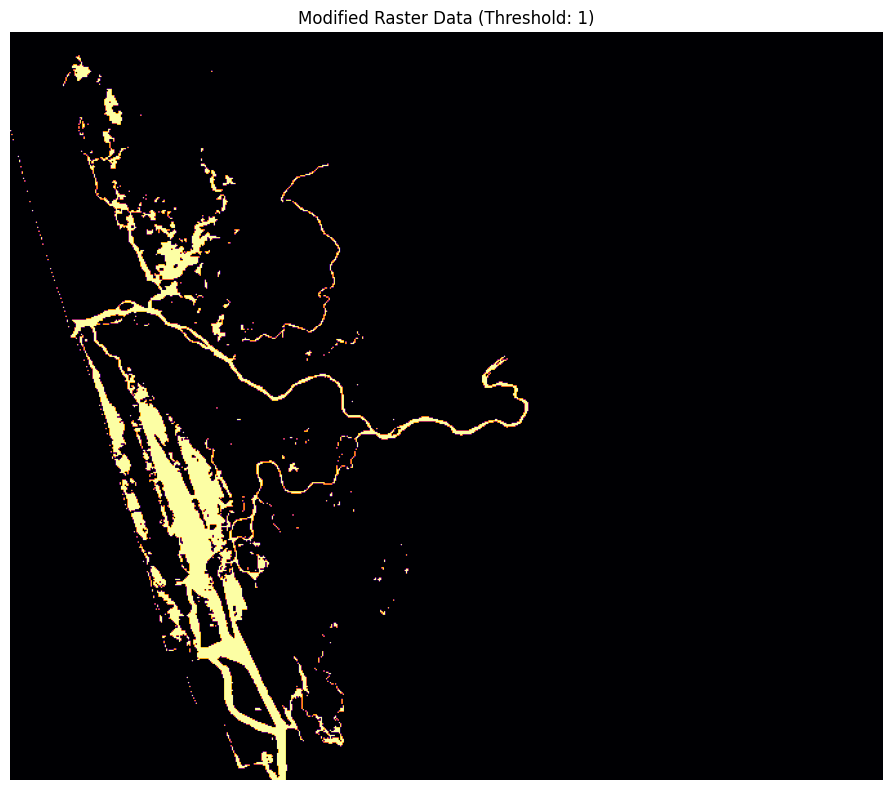

Projection to EPSG:4326 successful.
Attribute Table:
FID	Value	MinX	MinY	MaxX	MaxY
0	1	76.16569526046233	10.3547044665	76.16902581845937	10.358867664
1	1	76.25312240788479	10.3480433505	76.25395504738404	10.34887599
2	1	76.16153206296602	10.347210710999999	76.16236470246528	10.3480433505
3	1	76.1598667839675	10.3447127925	76.16153206296602	10.347210710999999
4	1	76.18068277144904	10.3447127925	76.18234805044756	10.346378071499998
5	1	76.16319734196455	10.342214874	76.17568693445347	10.3547044665
6	1	76.15903414446824	10.342214874	76.1598667839675	10.3447127925
7	1	76.15820150496897	10.340549594999999	76.15903414446824	10.342214874
8	1	76.17901749245051	10.3413822345	76.1815154109483	10.343880152999999
9	1	76.15736886546972	10.338884316	76.15820150496897	10.340549594999999
10	1	76.18068277144904	10.3397169555	76.1815154109483	10.340549594999999
11	1	76.2073272354254	10.3197336075	76.20815987492466	10.320566246999999
12	1	76.16819317896011	10.317235688999999	76.16985845795864	10.31890096

In [ ]:

# # Install necessary packages
# # !pip install numpy

# import osgeo.gdal as gdal
# import numpy as np
# import matplotlib.pyplot as plt
# from osgeo import gdal, ogr
# from osgeo import ogr
# from google.colab import drive

# def process_raster_data(input_filename, output_filename, output_vector_filename, threshold):
#     """
#     Process raster data by converting grid values less than or equal to the threshold as 1 and rest as -9999.9,
#     then save the modified data to a new TIFF file and create a vector shapefile from the modified raster.

#     Args:
#         input_filename (str): The path to the input TIFF file.
#         output_filename (str): The path to the output TIFF file.
#         output_vector_filename (str): The path to the output vector shapefile.
#         threshold (float): The threshold value for processing the raster data.
#     """

#     # Check if the file was opened successfully
#     if gdal_data is None:
#         raise FileNotFoundError(f"Error: Could not open the input file: {input_filename}")

#     # Get the first raster band
#     gdal_band = gdal_data.GetRasterBand(1)

#     # Get the no-data value
#     nodataval = gdal_band.GetNoDataValue()
#     print(nodataval)
from osgeo import gdal

def process_raster_data(input_filename, output_filename, output_vector_filename, threshold):
    # Open the raster file
    gdal_data = gdal.Open(input_filename)

    # Check if the raster file was opened successfully
    if gdal_data is None:
        print(f"Failed to open the raster file: {input_filename}")
        return  # Exit the function if the file cannot be opened

    # Get the first raster band
    gdal_band = gdal_data.GetRasterBand(1)

    # Get the no-data value
    nodataval = gdal_band.GetNoDataValue()
    print(f"No Data Value: {nodataval}")

    # Continue with your processing...
    # Convert the TIFF data to a numpy array
    data_array = gdal_data.ReadAsArray().astype(float)

    # Replace missing values with NaN if necessary
    # if np.any(data_array == nodataval):
    #     data_array[data_array == nodataval] = np.nan

    # Convert raster grid values: set values <= threshold as 1 and others as -9999.9
    data_array = np.where(np.logical_and(data_array > nodataval, data_array <= threshold), 1, -9999.9)

    # gdal_band.SetNoDataValue(-9999.9)

    # Create a new TIFF file
    driver = gdal.GetDriverByName('GTiff')
    output_data = driver.Create(output_filename, data_array.shape[1], data_array.shape[0], 1, gdal.GDT_Float32)

    # Set the geotransform and projection from the original file
    output_data.SetGeoTransform(gdal_data.GetGeoTransform())
    output_data.SetProjection(gdal_data.GetProjection())

    # Write the modified array to the new file
    output_band = output_data.GetRasterBand(1)
    output_band.WriteArray(data_array)

    # Close the output file
    output_data = None

    # Plot the modified raster data
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(f"Modified Raster Data (Threshold: {threshold})")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    plt.imshow(data_array, cmap="inferno", extent=(gdal_data.GetGeoTransform()[0],
                                                gdal_data.GetGeoTransform()[0] + gdal_data.GetGeoTransform()[1] * data_array.shape[1],
                                                gdal_data.GetGeoTransform()[3] + gdal_data.GetGeoTransform()[5] * data_array.shape[0],
                                                gdal_data.GetGeoTransform()[3]))

    ax.axis('off')  # Turn off the axis
    plt.tight_layout()  # Adjust layout to fit the figure area

    plt.show()

    # Convert the modified raster to a vector shapefile in WGS 84 projection
    raster_to_vector(output_filename, output_vector_filename)

def raster_to_vector(input_raster, output_vector):
    """
    Convert a raster file to a vector shapefile with an attribute table.

    Args:
        input_raster (str): The path to the input raster file.
        output_vector (str): The path to the output vector shapefile.
    """

    # Open raster dataset
    raster_ds = gdal.Open(input_raster)

    if raster_ds is None:
        raise Exception(f"Could not open raster file {input_raster}")

    # Get the raster band
    raster_band = raster_ds.GetRasterBand(1)

    # Get the no-data value
    no_data_value = raster_band.GetNoDataValue()

    # Create output vector file with WGS 84 projection
    driver = ogr.GetDriverByName("ESRI Shapefile")
    vector_ds = driver.CreateDataSource(output_vector)

    if vector_ds is None:
        raise Exception(f"Could not create vector file {output_vector}")

    # Define WGS 84 spatial reference
    srs = ogr.osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # EPSG code for WGS 84

    # Create layer with specified spatial reference
    layer = vector_ds.CreateLayer("layer", srs=srs, geom_type=ogr.wkbPolygon)
   # Add fields to store the value (1 or 0) and FID
    field_defn_value = ogr.FieldDefn("Value", ogr.OFTInteger)
    layer.CreateField(field_defn_value)

    field_defn_fid = ogr.FieldDefn("FID", ogr.OFTInteger)
    layer.CreateField(field_defn_fid)
    # Create a mask to select only pixels with value 1
    mask_array = raster_band.ReadAsArray() == 1
    mask_band = gdal.GetDriverByName('MEM').Create('', raster_band.XSize, raster_band.YSize, 1, gdal.GDT_Byte)
    mask_band.GetRasterBand(1).WriteArray(mask_array.astype(int))

    # Polygonize with mask
    gdal.Polygonize(raster_band, mask_band.GetRasterBand(1), layer, 0, [], callback=None)

    # Assign unique identifiers to each feature
    for fid, feature in enumerate(layer):
        feature.SetField("FID", fid)  # Set the FID field to the current index
        layer.SetFeature(feature)
    # Clean up
    raster_ds = None
    vector_ds = None

    # Print projection success message
    print("Projection to EPSG:4326 successful.")

    # Print the generated attribute table
    print_attribute_table(output_vector)

def print_attribute_table(vector_file):
    """
    Print the attribute table of the vector shapefile, including bounding box coordinates.

    Args:
        vector_file (str): The path to the vector shapefile.
    """
    # Open the vector dataset
    vector_ds = ogr.Open(vector_file)

    if vector_ds is None:
        raise Exception(f"Could not open vector file {vector_file}")

    # Get the first layer
    layer = vector_ds.GetLayer(0)

    # Print the attribute table header
    print("Attribute Table:")
    print("FID\tValue\tMinX\tMinY\tMaxX\tMaxY")

    # Dictionary to count occurrences of each value
    value_count = {}

    # Iterate through the features and print the attributes
    for feature in layer:
        fid = feature.GetFID()
        # Feature ID
        value = feature.GetField("Value")  # Get the value field
        geometry = feature.GetGeometryRef()  # Get the geometry

        # Get bounding box coordinates
        envelope = geometry.GetEnvelope()  # Returns (minX, maxX, minY, maxY)
        min_x, max_x, min_y, max_y = envelope

        print(f"{fid}\t{value}\t{min_x}\t{min_y}\t{max_x}\t{max_y}")
        # Count occurrences of each value
        if value in value_count:
            value_count[value] += 1
        else:
            value_count[value] = 1

    # Print counts of values present in the polygons
    print("\nCount of Values Present in Polygons:")
    for val, count in value_count.items():
        print(f"Value: {val}, Count: {count}")


    # Clean up
    vector_ds = None


# Example usage:
input_tiff = "/content/drive/MyDrive/Lowerbasin/lower_coastaldem_basin.tif"
# thresholds = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
thresholds = [1]
for threshold in thresholds:
    output_tiff = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}LOWER.tif"
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    process_raster_data(input_tiff, output_tiff, output_shp, threshold)


In [ ]:
!pip install gdal
!apt install gdal-bin python-gdal python3-gdal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python-gdal is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  gdal-bin

E: Package 'python-gdal' has no installation candidate


In [ ]:
import geopandas as gpd

# Define the output shapefile path
thresholds = [15]
for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Load the shapefile
    gdf = gpd.read_file(output_shp)

    # Reproject the GeoDataFrame to EPSG:32643
    gdf_projected = gdf.to_crs(epsg=32643)

    # Calculate the area of each polygon in square kilometers
    gdf_projected['area_km2'] = gdf_projected.area / 10**6

    # Print the GeoDataFrame with polygon IDs and areas
    print(gdf_projected[['geometry', 'area_km2']])

    # Calculate the total area of all polygons
    total_area = gdf_projected['area_km2'].sum()

    # Create a summary DataFrame
    summary_df = gpd.GeoDataFrame({
        'FID': gdf_projected.index,  # Using index as FID
        'Area (km²)': gdf_projected['area_km2']
    })

    # Create a new GeoDataFrame for the total area
    total_area_df = gpd.GeoDataFrame({'FID': ['Total'], 'Area (km²)': [total_area]})

    # Concatenate the summary DataFrame and the total area DataFrame
    summary_df = gpd.pd.concat([summary_df, total_area_df], ignore_index=True)

    # Print the summary DataFrame
    print(summary_df)

                                             geometry     area_km2
0   POLYGON ((651229.575 1146523.495, 651685.444 1...     0.083961
1   POLYGON ((652597.587 1146437.37, 652688.762 11...     0.008396
2   POLYGON ((653418.969 1146256.798, 653510.144 1...     0.016793
3   POLYGON ((653785.701 1145797.967, 653876.877 1...     0.008396
4   POLYGON ((653877.284 1145706.281, 653968.46 11...     0.008396
..                                                ...          ...
76  POLYGON ((645999.864 1110219.395, 646091.129 1...     0.008404
77  POLYGON ((646912.52 1110223.107, 647003.786 11...     0.008404
78  POLYGON ((647104.446 1107921.762, 647195.718 1...     0.016810
79  POLYGON ((647013.925 1107737.223, 647105.197 1...     0.008405
80  POLYGON ((633087.283 1146265.314, 633269.621 1...  1064.322970

[81 rows x 2 columns]
      FID   Area (km²)
0       0     0.083961
1       1     0.008396
2       2     0.016793
3       3     0.008396
4       4     0.008396
..    ...          ...
77     77   

In [ ]:
import geopandas as gpd

# Define the output shapefile path for shp1
thresholds = [15]
for threshold in thresholds:
    output_shp = f"/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"

    # Load the shapefile (shp1)
    shp1_gdf = gpd.read_file(output_shp)

    # Load the boundary shapefile (shp2)
    boundary_gdf = gpd.read_file('/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp')

    # Reproject both GeoDataFrames to EPSG:32643
    projected_crs = 'EPSG:32643'
    shp1_projected = shp1_gdf.to_crs(projected_crs)
    boundary_projected = boundary_gdf.to_crs(projected_crs)

    # Create a table to store the results
    results = []

    # Loop through each polygon in the boundary shapefile
    for i, polygon in boundary_projected.iterrows():
        # Clip the shp1 within the current polygon
        clipped_features = gpd.clip(shp1_projected, polygon.geometry)

        # Calculate the area of the clipped features in square kilometers
        clipped_area = clipped_features.area.sum() / 10**6  # Convert from m² to km²

        # Append the results to the table
        results.append({
            'Polygon Name': polygon['name'],  # Assuming 'name' is the field for polygon names
            'Clipped Area (km²)': clipped_area
        })

    # Create a DataFrame from the results
    results_df = gpd.GeoDataFrame(results)

    # # Calculate the total area of all clipped features
    # total_clipped_area = results_df['Clipped Area (km²)'].sum()

    # # Append a row for the total clipped area
    # total_row = {'Polygon Name': 'Total Clipped', 'Clipped Area (km²)': total_clipped_area}
    # results_df = results_df.append(total_row, ignore_index=True)

    # Print the results
    print(results_df[['Polygon Name', 'Clipped Area (km²)']])

                    Polygon Name  Clipped Area (km²)
0                          Kochi           99.682437
1                      Kodassery            3.029595
2                      Pariyaram            7.621495
3                         Meloor           12.352472
4                        Koratty            8.198466
..                           ...                 ...
69                         Eloor           13.052005
70  Choornikkara Gramapanchayath            7.713919
71                   Kalamassery           32.439343
72      Edathala Gramapanchayath           13.196575
73                        Maradu           11.959777

[74 rows x 2 columns]
